In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.stats import norm
from scipy.optimize import brentq, fsolve, minimize_scalar

## Bachelier (1990), Black (1976), QNM (2023) classes

Bachelier (1990)
\begin{align*}
& dF_t = \sigma_a dW_t \\\\
& C_{BC}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [(F-K)N(m_a) + \sigma_a\sqrt{\tau}n(m_a)] \\
& P_{BC}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [(K-F)(1-N(m_a)) + \sigma_a\sqrt{\tau}n(m_a)] \\\\
&\textit{ where} \\
&\ m_a = \frac{F-K}{\sigma_a \sqrt{\tau}}
\end{align*} \\

Black (1976)
\begin{align*}
& dF_t = \sigma_G F_tdW_t \\\\
& C_{BL}(F, K,\sigma_G, r,\tau) = e^{-r\tau} \ [FN(m_G + \frac{\sigma_G\sqrt{\tau}}{2}) - KN(m_G - \frac{\sigma_G\sqrt{\tau}}{2})] \\
& P_{BL}(F, K,\sigma_G, r,\tau) = e^{-r\tau} \ [K(1-N(m_G - \frac{\sigma_G\sqrt{\tau}}{2})) - F(1-N(m_G + \frac{\sigma_G\sqrt{\tau}}{2}))] \\\\
& \textit{ where} \\
&\ m_G = \frac{ln(F-K)}{\sigma_G \sqrt{\tau}}
\end{align*} \\


Quadratic Normal Model (Bouchouev, 2023)

\begin{align*}
&dF_t = \sigma(F_t)dW_t = (\sigma_{ATM} + a + bF_t + c F_t^2)dW_t\\\\
&C(F, K, a, b, c, r,\tau) = C_{BC}(F, K, \sigma_a = \sigma_{ATM}, r, \tau) + e^{-r\tau}U\\
&P(F, K, a, b, c, r,\tau) = P_{BC}(F, K, \sigma_a = \sigma_{ATM}, r, \tau) + e^{-r\tau}U\\\\  
& \textit{where}\\
&\ U = \sqrt{\tau}n(\frac{F-K}{\sigma_{ATM}\sqrt{\tau}})[a+\frac{b}{2}(F+K) + \frac{c}{3}(F^2+FK+K^2+\frac{\sigma_{ATM}^2\tau}{2})]
\end{align*}

In [2]:
# Bachelier (1900)
class Bachelier:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K, vol = None, option_type = 'call'):
      '''
      Bachelier formula
      return call/put option price
      '''
      # default parameter (to compute implied vol)
      if vol == None:
        vol = self.vol

      m = (self.F - K) / (vol * self.tau**0.5)
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ((self.F - K) * norm.cdf(m) + vol * self.tau**0.5 * norm.pdf(m))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ((K - self.F) * (1 - norm.cdf(m)) + vol * self.tau**0.5 * norm.pdf(m))



# Black (1976)
class Black:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K, vol = None, option_type = 'call'):
      '''
      Black formula
      return call/put option price
      '''
      # default parameter (to compute implied vol)
      if vol == None:
        vol = self.vol

      m = np.log(self.F / K) / (vol * self.tau**0.5)
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ( self.F * norm.cdf(m + 0.5*vol*self.tau**0.5) -
                                                    K * norm.cdf(m - 0.5*vol*self.tau**0.5))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ( K * (1 - norm.cdf(m - 0.5*vol*self.tau**0.5)) -
                                                    self.F * (1 - norm.cdf(m + 0.5*vol*self.tau**0.5)))



# Quadratic Normal Model (2023)
class QNM:
    def __init__(self, F, sig_atm, a, b, c, r, tau):
      self.F = F
      self.sig_atm = sig_atm
      self.a = a
      self.b = b
      self.c = c
      self.r = r
      self.tau = tau


    def option_pricer(self, K, option_type = 'call'):
      '''
      The method of linearization
      return call/put option price
      '''
      m = (self.F - K)/(self.sig_atm * self.tau**0.5)
      C_BC = np.exp(-self.r * self.tau) * ((self.F - K)*norm.cdf(m) + self.sig_atm * self.tau**0.5 * norm.pdf(m))
      P_BC = np.exp(-self.r * self.tau) * ((K - self.F)*(1-norm.cdf(m)) + self.sig_atm * self.tau**0.5 * norm.pdf(m))
      U = self.tau**0.5 * norm.pdf(m) * (self.a + self.b*(self.F + K)/2 +
                            self.c*(self.F**2 + self.F*K + K**2 + 0.5*self.sig_atm**2*self.tau)/3)

      if option_type == 'call':
        return C_BC + U*np.exp(-self.r * self.tau)
      elif option_type == 'put':
        return P_BC + U*np.exp(-self.r * self.tau)


    def implicit_FD(self, K, option_type = 'call'):
      '''
      The implicit finite difference
      return call/put option price
      '''
      # PDE: V_t + aV_ff + bV_f + cV = 0
      a = lambda f : 0.5 * (self.sig_atm + self.a + self.b*f + self.c*f**2)**2
      b = lambda f : 0
      c = lambda f : -self.r

      # Grid Parameters
      f_max = self.F + 100                                                        # space upper boundary
      f_min = self.F - 100                                                        # space lower boundary
      M = int(8*(f_max-f_min)) + 1                                                # the number of space steps
      N = int(100*252*self.tau)                                                   # the number of time steps

      # Grid Construction
      arr_f, df = np.linspace(f_min, f_max, M, retstep=True)                      # space discretization
      arr_t, dt = np.linspace(0, self.tau, N, retstep=True)                       # time discretization
      V = np.zeros((M, N))                                                        # grid initialization
      if option_type == 'call':
          V[:,0] = np.maximum(0, arr_f - K)                                       # European call option payoff (terminal condition)
          V[0,:] = 0                                                              # boundary condition
          V[-1,:] = (f_max - K) * np.exp(-self.r*arr_t)                           # boundary condition
      elif option_type == 'put':
          V[:,0] = np.maximum(0, K - arr_f)                                       # European put option payoff (terminal condition)
          V[0,:] = (K - f_min)* np.exp(-self.r*arr_t)                             # boundary condition
          V[-1,:] = 0                                                             # boundary condition

      # Matrix Construction
      alpha = lambda f : -a(f)*dt/df**2 + b(f)*dt/2/df
      beta = lambda f : 1 + 2*a(f)*dt/df**2 - c(f)*dt
      gamma = lambda f : -a(f)*dt/df**2 - b(f)*dt/2/df

      D = np.zeros(shape = (M-2,M-2))
      D[0,0], D[0,1], D[-1,-2], D[-1,-1] = beta(arr_f[1]), gamma(arr_f[1]), alpha(arr_f[-2]), beta(arr_f[-2])
      for m in range(1, M-3):
          D[m,m-1], D[m,m], D[m,m+1] = alpha(arr_f[m+1]), beta(arr_f[m+1]), gamma(arr_f[m+1])
      D = sparse.csr_matrix(D)

      # Grid Computation
      rem = np.zeros(shape = (M-2,))
      for n in range(1,N):
          rem[0], rem[-1] = alpha(arr_f[1])*V[0,n-1], gamma(arr_f[-2])*V[-1,n-1]
          V[1:-1,n] =  sparse.linalg.spsolve(D, V[1:-1, n-1] - rem)

      return V[ round( (self.F - f_min)/df), -1]


## IBV and INV function

In [3]:
# IBV and INV
def implied_volatility(option_price, F, K, r, tau, option_type = 'call', model = 'black', method='brent', disp=True):
    """
        Return Implied volatility
        model: black (default), bachelier
        methods: brent (default), fsolve, minimization
    """
    # model
    if model == 'bachelier':
      bachelier_ = Bachelier(F, 30, r, tau)
      obj_fun = lambda vol : option_price - bachelier_.option_pricer(K = K, vol = vol, option_type = option_type)
    else: # model == 'black'
      black_ = Black(F, 0.1, r, tau)
      obj_fun = lambda vol : option_price - black_.option_pricer(K = K, vol = vol, option_type = option_type)

    # numerical method
    if method == 'minimization':
      obj_square = lambda vol : obj_fun(vol)**2
      res = minimize_scalar( obj_square, bounds=(1e-15, 8), method='bounded')
      if res.success == True:
        return res.x
    elif method == 'fsolve':
        X0 = [0.1, 0.5, 1, 3]   # set of initial guess points
        for x0 in X0:
            x, _, solved, _ = fsolve(obj_fun, x0, full_output=True, xtol=1e-8)
            if solved == 1:
              return x[0]
    else:
        x, r = brentq( obj_fun, a = 1e-15, b = 500, full_output = True)
        if r.converged == True:
          return x

    # display strikes with failed convergence
    if disp == True:
      print(method, K)
    return -1

## Derman's approximation

In Chapter 16 of The Volatility Smile, Derman approximated local volatility by calculating the average of local volatilities between the current underlying price $F$ and the strike price $K$. Given the quadratic normal local volatility, i.e. $\sigma(f)=\sigma_{ATM} + a + bf + cf^2$, the implied normal volatility estimated by Derman's approximation becomes:

\begin{align*}
INV(K, F)
& \approx \frac{1}{K-F}\int^K_F\sigma(f)df\\
& = \frac{1}{K-F}\int^K_F(\sigma_{ATM} + a + bf + c f^2)dx\\
& = \sigma_{ATM} + a + \frac{b}{2}(K+F) + \frac{c}{3}(K^2+KF+F^2)\\
\end{align*}

In [4]:
# QNM parameters
sig_atm, a, b, c = 20, 72, -2.4 ,0.02                 # 20 + 0.02*(F-60)^2
futures_price = 60.0
risk_free_rate = 0.0
time_to_maturity = 2.0

# local vol
sig_qnm = lambda f : sig_atm + a + b*f + c*f**2

# Derman's approximation
derman = lambda k : sig_atm + a + b/2*(k + futures_price) + c/3*(k**2 + k*futures_price + futures_price**2)

In [5]:
step_size_f = 1.0
arr_f = np.arange(40, 80 + step_size_f/2, step_size_f)

# compute call prices across strikes
qnm = QNM(futures_price, sig_atm, a, b, c, risk_free_rate, time_to_maturity)
arr_call_formula = qnm.option_pricer(K = arr_f, option_type = 'call')
list_call_fd = []
for k_ in arr_f:
    list_call_fd.append(qnm.implicit_FD(k_, option_type = 'call'))
arr_call_fd = np.array(list_call_fd)

# compute the corresponding INVs across strikes
list_inv_formula = []
list_inv_fd = []
for stirke_, call_formula_, call_fd_ in zip(arr_f, arr_call_formula, arr_call_fd):
    list_inv_formula.append(implied_volatility(call_formula_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                                    option_type = 'call', model = 'bachelier', method='brent', disp=True))
    list_inv_fd.append(implied_volatility(call_fd_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                                    option_type = 'call', model = 'bachelier', method='brent', disp=True))
arr_inv_formula = np.array(list_inv_formula)
arr_inv_fd = np.array(list_inv_fd)

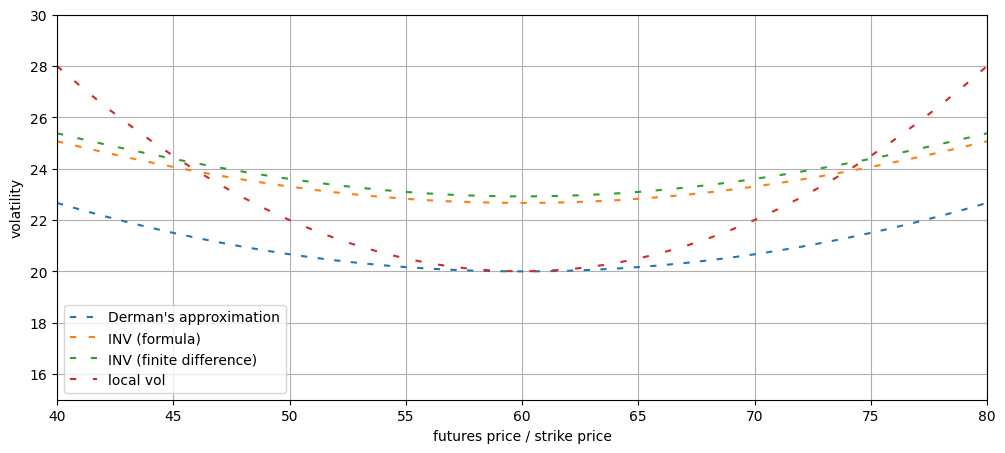

In [6]:
# plot the local vol, INVs, and Derman's approximation
arr_derman = derman(arr_f)
plt.figure(figsize=(12,5))

plt.plot(arr_f, arr_derman, label = 'Derman\'s approximation', linestyle = (0,(3,5)))
plt.plot(arr_f, arr_inv_formula, label = 'INV (formula)', linestyle = (0,(3,6)))
plt.plot(arr_f, arr_inv_fd, label = 'INV (finite difference)', linestyle = (0,(3,7)))
plt.plot(arr_f, sig_qnm(arr_f), label = 'local vol', linestyle = (0,(3,8)))

plt.xlabel('futures price / strike price')
plt.ylabel('volatility')
plt.xlim(40,80)
plt.ylim(15,30)
plt.grid()
plt.legend()

plt.show()

## Revised Derman's approximation

One notable limitation of Derman's approximation is its insensitivity to the time to maturity. When we consider the quadratic normal model with the current underlying price corresponding to the vertex (minimum value) of the parabola, the implied normal volatility should increase as the time to maturity extends. This is because, over a longer time frame, the underlying price is more likely to move outward and accumulate higher local volatility. However, Derman's approximation always yields the vertex value, regardless of the time to maturity.

To address this limitation, we have developed a revised version of Derman's approximation by introducing an additional term that is related to the time to maturity. This revised approximation can be readily derived using the quadratic normal formula and Taylor expansion.

\begin{align*}
INV(K, F)
& \approx \sigma_{ATM} + a + \frac{b}{2}(K+F) + \frac{c}{3}(K^2+KF+F^2) + \frac{c}{6}\sigma_{ATM}^2\tau\\
\end{align*}

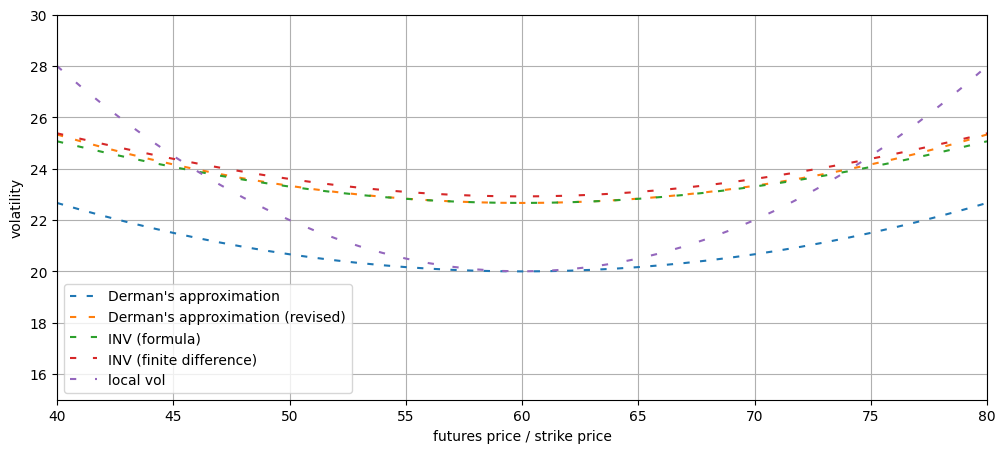

In [7]:
# Derman's approximation (revised)
derman_revised = lambda k : sig_atm + a + b/2*(k + futures_price) +\
                               c/3*(k**2 + k*futures_price + futures_price**2) + c/6*sig_atm**2*time_to_maturity

# plot the local vol, INVs, and Derman's approximations
arr_derman_revised = derman_revised(arr_f)
plt.figure(figsize=(12,5))

plt.plot(arr_f, arr_derman, label = 'Derman\'s approximation', linestyle = (0,(3,5)))
plt.plot(arr_f, arr_derman_revised, label = 'Derman\'s approximation (revised)', linestyle = (0,(3,6)))
plt.plot(arr_f, arr_inv_formula, label = 'INV (formula)', linestyle = (0,(3,7)))
plt.plot(arr_f, arr_inv_fd, label = 'INV (finite difference)', linestyle = (0,(3,8)))
plt.plot(arr_f, sig_qnm(arr_f), label = 'local vol', linestyle = (0,(3,9)))

plt.xlabel('futures price / strike price')
plt.ylabel('volatility')
plt.xlim(40,80)
plt.ylim(15,30)
plt.grid()
plt.legend()

plt.show()

## Onging exploration

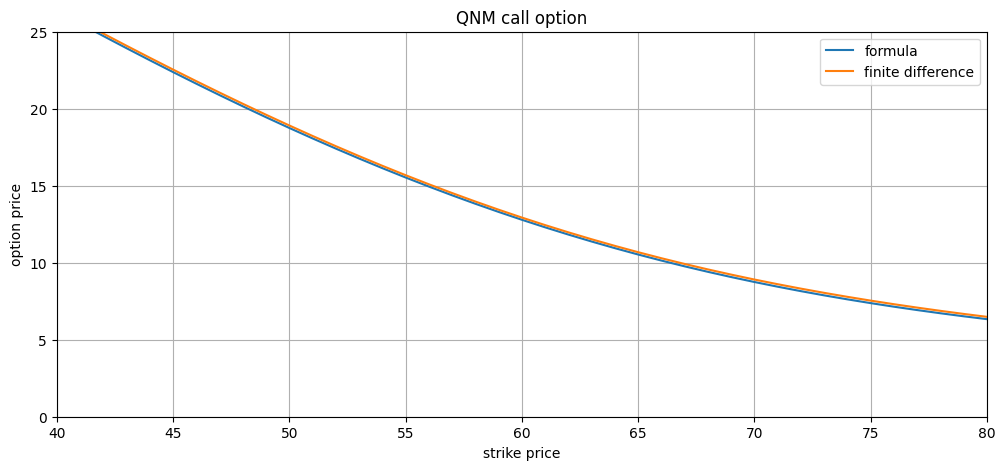

In [8]:
# plot the call prices
plt.figure(figsize=(12,5))
plt.plot(arr_f, arr_call_formula, label = 'formula')
plt.plot(arr_f, list_call_fd, label = 'finite difference')

plt.title('QNM call option')
plt.xlabel('strike price')
plt.ylabel('option price')
plt.xlim(40,80)
plt.ylim(0,25)
plt.grid()
plt.legend()

plt.show()

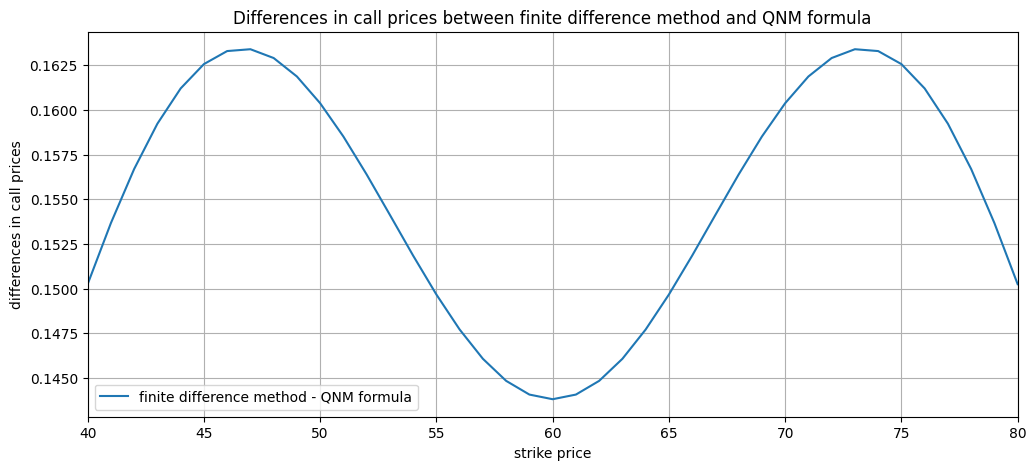

In [9]:
# plot the differences in call prices between finite difference method and QNM formula
plt.figure(figsize=(12,5))
plt.plot(arr_f, list_call_fd - arr_call_formula, label = 'finite difference method - QNM formula')

plt.title('Differences in call prices between finite difference method and QNM formula')
plt.xlabel('strike price')
plt.ylabel('differences in call prices')
plt.xlim(40,80)
plt.grid()
plt.legend()

plt.show()

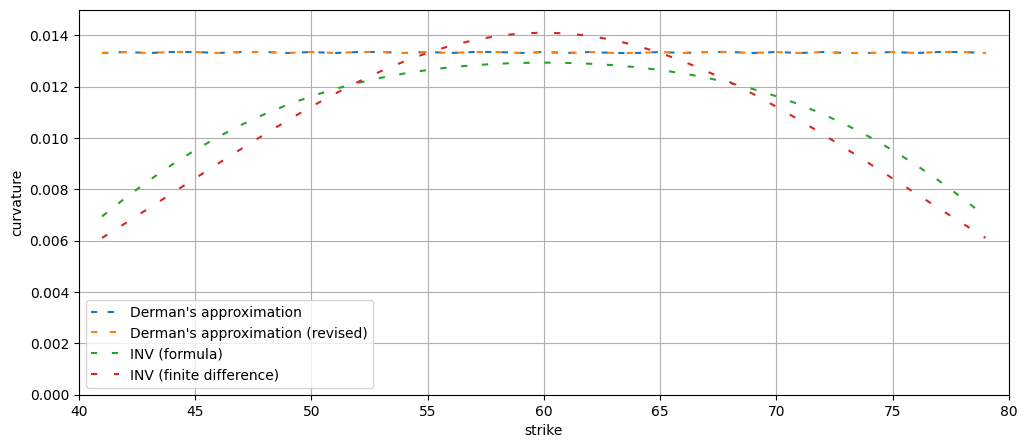

In [10]:
# compute the corresponding curvatures across strikes for INVs and Derman's approximations
arr_curve_formula = (arr_inv_formula[2:] + arr_inv_formula[:-2] - 2*arr_inv_formula[1:-1])/step_size_f**2
arr_curve_fd = (arr_inv_fd[2:] + arr_inv_fd[:-2] - 2*arr_inv_fd[1:-1])/step_size_f**2
arr_curve_derman = (arr_derman[2:] + arr_derman[:-2] - 2*arr_derman[1:-1])/step_size_f**2
arr_curve_derman_revised = (arr_derman_revised[2:] + arr_derman_revised[:-2] - 2*arr_derman_revised[1:-1])/step_size_f**2

# plot the curvatures for INVs and Derman's approximations
plt.figure(figsize=(12,5))

plt.plot(arr_f[1:-1], arr_curve_derman, label = 'Derman\'s approximation', linestyle = (0,(3,5)))
plt.plot(arr_f[1:-1], arr_curve_derman_revised, label = 'Derman\'s approximation (revised)', linestyle = (0,(3,6)))
plt.plot(arr_f[1:-1], arr_curve_formula, label = 'INV (formula)', linestyle = (0,(3,7)))
plt.plot(arr_f[1:-1], arr_curve_fd, label = 'INV (finite difference)', linestyle = (0,(3,8)))

plt.xlabel('strike')
plt.ylabel('curvature')
plt.xlim(40,80)
plt.ylim(0,0.015)
plt.grid()
plt.legend()

plt.show()